# Exploratory Data Analysis

This notebook is intended for the development of data pipelines and exploratory data analysis.

**Raw data sources:**
- Elexon BMRS API
    - [Documentation page](https://bmrs.elexon.co.uk/api-documentation/introduction)
- UK Met Office:
    - [Hourly weather data](https://catalogue.ceda.ac.uk/uuid/99173f6a802147aeba430d96d2bb3099/)
    - [Hourly solar radiation data](https://catalogue.ceda.ac.uk/uuid/76e54f87291c4cd98c793e37524dc98e/)

**Citations:**
- Met Office (2025): MIDAS Open: UK hourly weather observation data, v202507. NERC EDS Centre for Environmental Data Analysis, 18 July 2025. doi:10.5285/99173f6a802147aeba430d96d2bb3099.
- Met Office (2025): MIDAS Open: UK hourly solar radiation data, v202507. NERC EDS Centre for Environmental Data Analysis, 18 July 2025. doi:10.5285/76e54f87291c4cd98c793e37524dc98e.

**Fuel types:**

- COAL 
- OIL 
- GAS, including
    - CCGT: Combined cycle gas turbine
    - OCGT: Open cycle gas turbine
- WIND 
- SOLAR
- NPSHYD: Non-pumped storage hydropower
- NUCLEAR
- BIOMASS
- PS: Pumped storage
- INTER:  Imports/exports from/to other grids via interconnectors
- OTHER

**Dataset explanations:**
- AGPT: Actual generation data per settlement period aggregrated by power system resource type
- FUELHH: Half-hourly generation outturn aggregrated by fuel type
- INDO (initial national demand outturn): Takes into account transmission losses but does not include station transformer load, pumped storage demand or interconnector demand.
- ITSDO (initial transmission system demand outturn): Takes into account transmission losses, station transformer load, pumped storage demand and interconnector demand.

**Weather data locations:**

Wind generation and heating demand are major drivers in GB electricity markets. We want to collect weather data from locations that reflect this. From looking at population density and proximity to major wind farms, the three chosen locations are: 
- Heathrow, Greater London: Major population centre and close to wind farms in the Thames Estuaray
- Crosby, Merseyside: Major population centre and close to wind farms in the Irish Sea
- Dyce, Aberdeenshire: Major population centre and close to wind farms in the North Sea

In [ ]:
# Import required dependencies
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('seaborn-v0_8-colorblind')

## 1. Collect electricity data from BMRS API

### 1.1 Half-hourly electricity generation data

In this section, we collect from two BMRS datasets, 'AGPT' and 'FUELHH', to get an accurate breakdown of the different energy sources.

The AGPT data does not include flows from interconnects, while the FUELHH data does not include energy generation from solar or embedded generation. In the following section, we will merge AGPT and FUELHH to get an accurate breakdown of the different energy generation sources in the UK for a given time period.

In [3]:
# note: maximum date range is 4 days
params = {
    "publishDateTimeFrom": "2025-02-01 00:00",
    "publishDateTimeTo": "2025-02-04 01:00",
    "format": "json"
}

Get generation data for each settlement perioid from AGPT:

In [4]:
# This dataset does not include flows from interconnects
url = "https://data.elexon.co.uk/bmrs/api/v1/datasets/AGPT/"
response = requests.get(url, params=params)
if response.ok:
    AGPT_data = response.json()  # parse JSON
else:
    print("Error:", response.status_code, response.text)

Unpack AGPT data into a dataframe:

In [5]:
df = pd.DataFrame(AGPT_data['data'])
df['startTime'] = pd.to_datetime(df['startTime'])

# Create pivot table with multi-level columns
df_AGPT = df.pivot_table(
    index=['settlementDate', 'settlementPeriod', 'startTime'], 
    columns='psrType', 
    values='quantity',
    aggfunc='first'
).reset_index()

# Sort by settlement date and period
df_AGPT = df_AGPT.sort_values(['settlementDate', 'settlementPeriod']).reset_index(drop=True)

# group onshore and offshore wind
df_AGPT['WIND'] = df_AGPT[['Wind Offshore', 'Wind Onshore']].sum(axis=1)
df_AGPT = df_AGPT.drop(columns=['Wind Offshore', 'Wind Onshore'])

# group hydro and other 
df_AGPT['OTHER'] = df_AGPT[['Hydro Pumped Storage', 'Hydro Run-of-river and poundage', 'Other']].sum(axis=1)
df_AGPT = df_AGPT.drop(columns=['Hydro Pumped Storage', 'Hydro Run-of-river and poundage', 'Other'])

# rename remaining columns
df_AGPT = df_AGPT.rename(columns={
    "Nuclear": "NUCLEAR",
    "Biomass": "BIOMASS",
    "Fossil Gas": "GAS",
    "Fossil Oil": "OIL",
    "Fossil Hard coal": "COAL",
    "Solar": "SOLAR"  
    })

# these should be the final generation types
gen_types_AGPT = {'NUCLEAR', 'BIOMASS', 'GAS', 'OIL', 'COAL', 'WIND', 'SOLAR', 'OTHER'}
cols = set(df_AGPT.columns) - {'startTime', 'settlementDate', 'settlementPeriod'}
assert cols == set(gen_types_AGPT)

# Display
df_AGPT.head()

psrType,settlementDate,settlementPeriod,startTime,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER
0,2025-01-31,47,2025-01-31 23:00:00+00:00,2212.0,15908.0,0.0,0.0,4273.0,0.0,3184.279,578.0
1,2025-01-31,48,2025-01-31 23:30:00+00:00,2444.0,13168.0,0.0,0.0,4269.0,0.0,3521.178,671.0
2,2025-02-01,1,2025-02-01 00:00:00+00:00,2521.0,12067.0,0.0,0.0,4263.0,0.0,4125.956,677.0
3,2025-02-01,2,2025-02-01 00:30:00+00:00,2557.0,11594.0,0.0,0.0,4276.0,0.0,4552.016,648.0
4,2025-02-01,3,2025-02-01 01:00:00+00:00,2550.0,11316.0,0.0,0.0,4266.0,0.0,5109.811,713.0


Plot AGPT data:

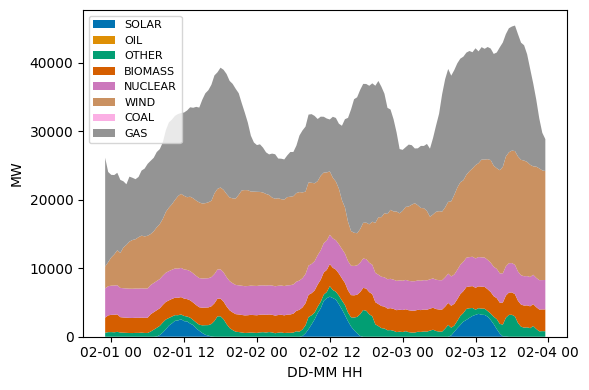

In [5]:
colors = sns.color_palette("colorblind", len(gen_types_AGPT))
fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
ax.stackplot(df_AGPT['startTime'], [df_AGPT[gt] for gt in gen_types_AGPT], labels=gen_types_AGPT, colors=colors)
ax.legend(fontsize=8)
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.show()

Get data from the FUELHH dataset:

In [6]:
url = "https://data.elexon.co.uk/bmrs/api/v1/datasets/FUELHH/"
response = requests.get(url, params=params)
if response.ok:
    FUELHH_data = response.json()  # parse JSON
else:
    print("Error:", response.status_code, response.text)

In [7]:
# Unpack FUELHH data into a dataframe
df = pd.DataFrame(FUELHH_data['data'])
df['startTime'] = pd.to_datetime(df['startTime'])

# Create pivot table with multi-level columns
df_FUELHH = df.pivot_table(
    index=['settlementDate', 'settlementPeriod', 'startTime'], 
    columns='fuelType', 
    values='generation',
    aggfunc='first'
).reset_index()

# Sort by settlement date and period
df_FUELHH = df_FUELHH.sort_values(['settlementDate', 'settlementPeriod']).reset_index(drop=True)

# Simplify FUELHH dataframe by grouping categories:
# group gas categories
df_FUELHH['GAS'] = df_FUELHH[['OCGT', 'CCGT']].sum(axis=1)
df_FUELHH = df_FUELHH.drop(columns=['OCGT', 'CCGT'])

# group interconnectors
interconnects = df_FUELHH.filter(regex='^INT')
total_interconnect = interconnects.sum(axis=1)
df_FUELHH = df_FUELHH.filter(regex='^(?!INT)')
df_FUELHH['INTER'] = total_interconnect

# group pumped storage, non-pumped hydro and other
df_FUELHH['OTHER'] = df_FUELHH[['OTHER', 'PS', 'NPSHYD']].sum(axis=1)
df_FUELHH = df_FUELHH.drop(columns=['PS', 'NPSHYD'])

# these should be are the final generation types
gen_types_FUELHH = {'NUCLEAR', 'BIOMASS', 'GAS', 'OIL', 'COAL', 'WIND', 'INTER', 'OTHER'}
cols = set(df_FUELHH.columns) - {'startTime', 'settlementDate', 'settlementPeriod'}
assert cols == gen_types_FUELHH

# display
df_FUELHH.head()

fuelType,settlementDate,settlementPeriod,startTime,BIOMASS,COAL,NUCLEAR,OIL,OTHER,WIND,GAS,INTER
0,2025-01-31,48,2025-01-31 23:30:00+00:00,2501,0,4275,0,650,2986,12650,5036
1,2025-02-01,1,2025-02-01 00:00:00+00:00,2553,0,4268,0,634,3504,11818,5414
2,2025-02-01,2,2025-02-01 00:30:00+00:00,2566,0,4270,0,675,3931,11354,5582
3,2025-02-01,3,2025-02-01 01:00:00+00:00,2418,0,4273,0,629,4441,11104,5000
4,2025-02-01,4,2025-02-01 01:30:00+00:00,2223,0,4275,0,589,4838,10192,5164


Align the time stamps and create full generation dataset by combining interconnect data from FUELHH with AGPT data

In [8]:
# Define settlement date range
start_date = '2025-02-01'
end_date = '2025-02-03'

# Filter by settlement date and period range
df_AGPT_filtered = df_AGPT[
    (df_AGPT['settlementDate'] >= start_date) & 
    (df_AGPT['settlementDate'] <= end_date)
].copy()

df_FUELHH_filtered = df_FUELHH[
    (df_FUELHH['settlementDate'] >= start_date) & 
    (df_FUELHH['settlementDate'] <= end_date)
].copy()

# Merge generation datasets on settlementDate and settlementPeriod
df_generation = df_AGPT_filtered.merge(
    df_FUELHH_filtered[['settlementDate', 'settlementPeriod', 'INTER']], 
    on=['settlementDate', 'settlementPeriod'],
    how='inner'
)

generation_types = gen_types_AGPT.union(gen_types_FUELHH)

# display
df_generation.head()

,settlementDate,settlementPeriod,startTime,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,INTER
0,2025-02-01,1,2025-02-01 00:00:00+00:00,2521.0,12067.0,0.0,0.0,4263.0,0.0,4125.956,677.0,5414
1,2025-02-01,2,2025-02-01 00:30:00+00:00,2557.0,11594.0,0.0,0.0,4276.0,0.0,4552.016,648.0,5582
2,2025-02-01,3,2025-02-01 01:00:00+00:00,2550.0,11316.0,0.0,0.0,4266.0,0.0,5109.811,713.0,5000
3,2025-02-01,4,2025-02-01 01:30:00+00:00,2237.0,10676.0,0.0,0.0,4277.0,0.0,5109.811,619.0,5164
4,2025-02-01,5,2025-02-01 02:00:00+00:00,2219.0,9671.0,0.0,0.0,4278.0,0.0,5956.036,593.0,5050


Plot merged data:

*Note: The interconnect data is negative when energy exports are greater than imports.* 

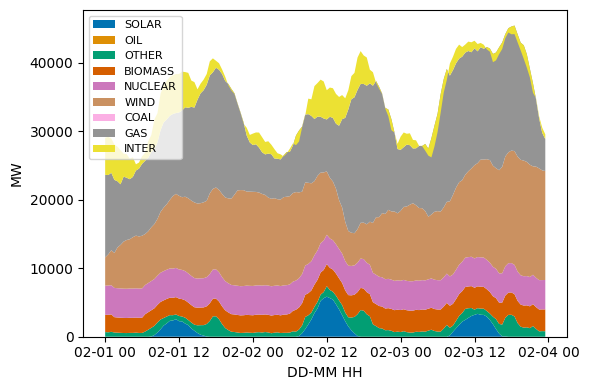

In [9]:
colors = sns.color_palette("colorblind", len(generation_types))
fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
ax.stackplot(df_generation['startTime'], [df_generation[gt] for gt in generation_types], labels=generation_types, colors=colors)
ax.legend(fontsize=8)
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.show()

### 1.2 Initial national demand outturn (INDO)

The INDO measures the half-hourly averaged demand metered by the transmission company in MW. 

In [10]:
# Make call to API
url = "https://data.elexon.co.uk/bmrs/api/v1/demand/outturn"

# note: maximum date range is 4 days
params = {
    "settlementDateFrom": "2025-02-01",
    "settlementDateTo": "2025-02-03",
    "settlementPeriod": np.arange(1, 50),
    "format": "json"
}

response = requests.get(url, params=params)

if response.ok:
    demand_data = response.json()  # parse JSON
else:
    print("Error:", response.status_code, response.text)

In [11]:
# Unpack data into a dataframe
df = pd.DataFrame(demand_data['data'])
df['startTime'] = pd.to_datetime(df['startTime'])

# Create pivot table with multi-level columns
df_demand = df.pivot_table(
    index=['settlementDate', 'settlementPeriod', 'startTime'], 
    values=['initialDemandOutturn','initialTransmissionSystemDemandOutturn']
).reset_index()

# Sort by settlement date and period
df_demand = df_demand.sort_values(['settlementDate', 'settlementPeriod']).reset_index(drop=True)

# Filter by settlement date range
df_demand = df_demand[
    (df_demand['settlementDate'] >= start_date) & 
    (df_demand['settlementDate'] <= end_date)
]

df_demand = df_demand.rename(columns={
    "initialDemandOutturn": "INDO",
    "initialTransmissionSystemDemandOutturn": "ITSO"
    })

df_demand.head()

,settlementDate,settlementPeriod,startTime,INDO,ITSO
0,2025-02-01,1,2025-02-01 00:00:00+00:00,27162.0,27972.0
1,2025-02-01,2,2025-02-01 00:30:00+00:00,27508.0,28145.0
2,2025-02-01,3,2025-02-01 01:00:00+00:00,27020.0,27637.0
3,2025-02-01,4,2025-02-01 01:30:00+00:00,26324.0,26945.0
4,2025-02-01,5,2025-02-01 02:00:00+00:00,25563.0,26247.0


Plot demand with the generation data:

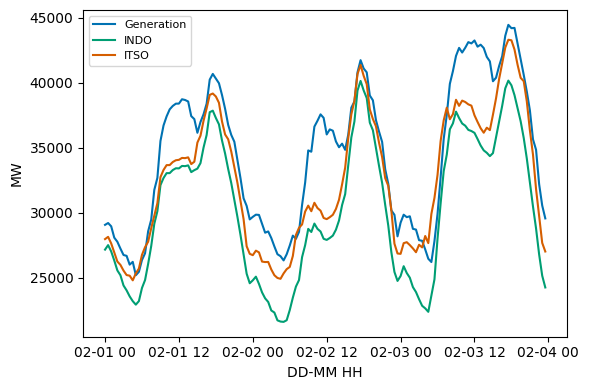

In [12]:
fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
ax.plot(df_generation['startTime'], df_generation[list(generation_types)].sum(axis=1), label='Generation')
ax.plot(df_demand['startTime'], df_demand['INDO'], label='INDO')
ax.plot(df_demand['startTime'], df_demand['ITSO'], label='ITSO')
ax.legend(fontsize=8)
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.show()

### 1.3 Market price index data

In [13]:
# Make call to API
url = "https://data.elexon.co.uk/bmrs/api/v1/balancing/pricing/market-index"

# note: maximum date range is 4 days
params = {
    "from": "2025-02-01 00:00",
    "to": "2025-02-04 00:00",
    "dataProviders": ["APX"],
    "format": "json"
}

response = requests.get(url, params=params)

if response.ok:
    price_data = response.json()  # parse JSON
else:
    print("Error:", response.status_code, response.text)

In [14]:
# Unpack data into a dataframe
df = pd.DataFrame(price_data['data'])
df['startTime'] = pd.to_datetime(df['startTime'])

# Create pivot table with multi-level columns
df_price = df.pivot_table(
    index=['settlementDate', 'settlementPeriod', 'startTime'], 
    values=['price', 'volume']
).reset_index()

# Sort by settlement date and period
df_price = df_price.sort_values(['settlementDate', 'settlementPeriod']).reset_index(drop=True)

# Filter by settlement date range
df_price = df_price[
    (df_price['settlementDate'] >= start_date) & 
    (df_price['settlementDate'] <= end_date)
]

df_price.head()

,settlementDate,settlementPeriod,startTime,price,volume
0,2025-02-01,1,2025-02-01 00:00:00+00:00,116.34,907.45
1,2025-02-01,2,2025-02-01 00:30:00+00:00,116.17,1051.50
2,2025-02-01,3,2025-02-01 01:00:00+00:00,109.65,1338.20
3,2025-02-01,4,2025-02-01 01:30:00+00:00,102.70,1241.55
4,2025-02-01,5,2025-02-01 02:00:00+00:00,100.13,1035.00


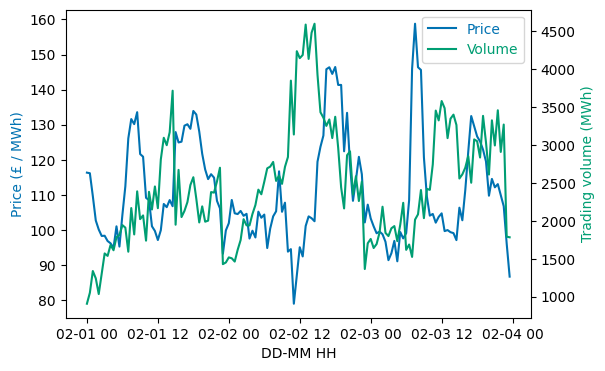

In [15]:
# Plot price and trading volume on twin axes
from mpl_toolkits.axes_grid1 import host_subplot

plt.figure(figsize=(6,4))
host = host_subplot(111)
par = host.twinx()

host.set_xlabel("DD-MM HH", fontsize=10)
host.set_ylabel("Price (£ / MWh)", fontsize=10)
par.set_ylabel("Trading volume (MWh)", fontsize=10)

p1, = host.plot(df_price['startTime'], df_price['price'], label="Price")
p2, = par.plot(df_price['startTime'], df_price['volume'], label="Volume")

host.legend(labelcolor="linecolor")

host.yaxis.label.set_color(p1.get_color())
par.yaxis.label.set_color(p2.get_color())

plt.show()

Plot price with demand and generation data:

In [16]:
df_demand['ITSO']

0      27972.0
1      28145.0
2      27637.0
3      26945.0
4      26247.0
        ...   
139    34476.0
140    31816.0
141    29774.0
142    27677.0
143    27017.0
Name: ITSO, Length: 144, dtype: float64

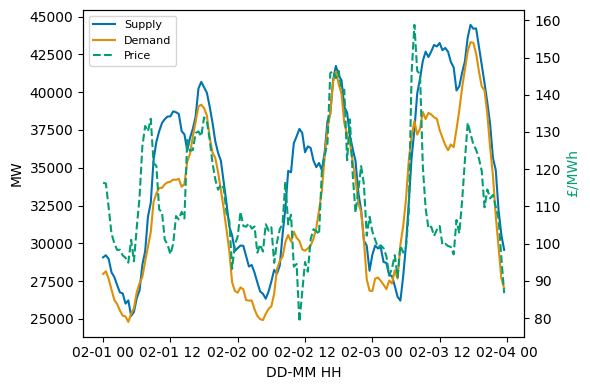

In [17]:
total_generation = df_generation[list(generation_types)].sum(axis=1)

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')

colors = sns.color_palette("colorblind", 3)

# Left axis - Power
ax.plot(df_generation['startTime'], total_generation, label='Supply', color=colors[0])
ax.plot(df_demand['startTime'], df_demand['ITSO'], label='Demand', color=colors[1])
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)

# Right axis - Price
ax2 = ax.twinx()
ax2.plot(df_price['startTime'], df_price['price'], label='Price', linestyle='--', color=colors[2])
ax2.set_ylabel('£/MWh', fontsize=10, color=colors[2])

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8)

plt.show()

### 1.5 Supply-demand analysis

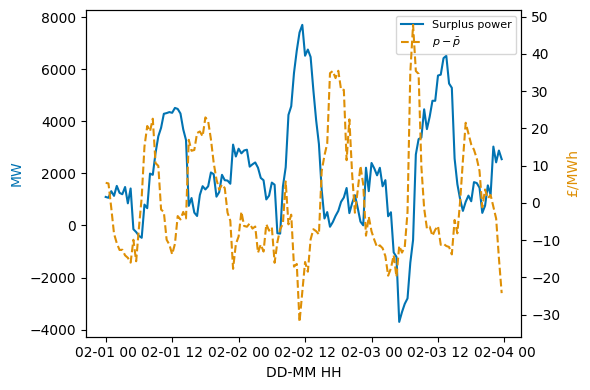

In [18]:
surplus = total_generation - df_demand['ITSO']
mean_price = np.mean(df_price['price'])

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')

# plot power surplus, i.e. energy generation - energy demand
ax.plot(df_generation['startTime'], surplus, label='Surplus power', color=colors[0])
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10, color=colors[0])
ax.legend(fontsize=8)

# plot price fluctuation from mean
ax2 = ax.twinx()
ax2.plot(df_price['startTime'], df_price['price'] - mean_price, label='$p - \\bar{p}$', linestyle='--', color=colors[1])
ax2.set_ylabel('£/MWh', fontsize=10, color=colors[1])

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8)
plt.show()

- For generated power larger than the demand for power, 'surplus power' is positive.
- For generated power smaller than the demand for power, 'surplus power' is negative.

In the previous plot, we see that prices are much higher than the mean when surplus power is large and negative, while prices are low when surplus power is large and positive. When supply approximately matches demand, the price lies near the mean. Qualitatively, these observations match what you would expect to see in a market where price is driven by supply and demand.

## 2. Data from Met Office

Let's get some weather from the Met Office which will be key to building models that can accurately forecast electricity prices.

**NB: Users need to download the relevant weather data themselves and update the load paths below accordingly.**

The weather station data can be found at the following links:
- [Heathrow](https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-202507/greater-london/00708_heathrow)
- [Crosby](https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-202507/merseyside/17309_crosby)
- [Dyce](https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-202507/aberdeenshire/00161_dyce)

*Weather dataset comments:*
- missing_value: NA
- ob_time: Date and time (YYYY-MM-DD HH:MM:SS) of the observation
- wind_speed_unit_id: Code to describe the origin of the wind speed units.
- wind_speed_unit_id=0: wind speed estimated (metres per second)
- wind_speed_unit_id=1: wind speed from anemometer (metres per second)
- wind_speed_unit_id=3: wind speed estimated (knots)
- wind_speed_unit_id=4: wind speed from anemometer (knots)
- wind_direction: wind direction in true degrees
- wind_speed: wind speed (knots)
- visibility: visibility (decametres)
- air_temperature: Air temperature (degrees celsius)

*Solar irradiation dataset comments:*
- glbl_irad_amt: Global solar irradiation amount (KJ/m^2)

Load weather data and construct a simplified dataset:

In [23]:
import os
import pandas as pd
import numpy as np

locations = ["heathrow", "crosby", "dyce"]
years = [2021, 2022, 2023, 2024]
KNOT_TO_MS = 0.514  # 1 knot = 0.514 m/s

dfs = []

for location in locations:
    base_dir = os.path.join("raw_data_met_office", location)
    weather_dir = os.path.join(base_dir, "weather")
    radiation_dir = os.path.join(base_dir, "solar_radiation")
    dfs_location = []

    for year in years:
        # Load hourly weather data
        weather_path = os.path.join(weather_dir, f"hourly_weather_{location}_{year}.csv")
        df_hw = pd.read_csv(weather_path, header=283, low_memory=False)
        df_hw = df_hw[['ob_time', 'wind_speed_unit_id', 'wind_speed', 'wind_direction', 
                       'visibility', 'air_temperature']]
        
        # Convert wind speed to m/s
        is_mps = df_hw['wind_speed_unit_id'].isin([0, 1])
        df_hw['wind_speed'] = df_hw['wind_speed'] * (is_mps + ~is_mps * KNOT_TO_MS)
        df_hw.drop(columns='wind_speed_unit_id', inplace=True)
        
        # Clean up data
        df_hw = df_hw.iloc[:-1]  # Drop last row ('end of data' line)
        df_hw['ob_time'] = pd.to_datetime(df_hw['ob_time'])
        
        # Load solar radiation data if available
        radiation_path = os.path.join(radiation_dir, f"solar_radiation_{location}_{year}.csv")
        if os.path.exists(radiation_path):
            df_rad = pd.read_csv(radiation_path, header=78, low_memory=False)
            df_rad = df_rad[['ob_end_time', 'glbl_irad_amt']].iloc[:-1]
            df_rad['ob_time'] = pd.to_datetime(df_rad['ob_end_time'])
            df_rad.drop(columns='ob_end_time', inplace=True)
            df_merged = df_hw.merge(df_rad, on='ob_time', how='left')
        else:
            print(f"Warning: No radiation data found for {location} {year}")
            df_hw['glbl_irad_amt'] = np.nan
            df_merged = df_hw
        
        dfs_location.append(df_merged)
    
    # Combine all years for this location
    df_location = pd.concat(dfs_location, ignore_index=True)
    df_location['location'] = location.capitalize()
    dfs.append(df_location)

# Combine all locations
df_weather = pd.concat(dfs, ignore_index=True)

# Write to disk
# df_weather.to_csv(os.path.join("data_met_office", "weatherGB_2021_to_2024.csv"))

# Display
df_weather.head()

,ob_time,wind_speed,wind_direction,visibility,air_temperature,glbl_irad_amt,location
0,2021-01-01 00:00:00,1.028,360.0,500.0,0.5,0.0,Heathrow
1,2021-01-01 01:00:00,1.028,340.0,350.0,0.2,0.0,Heathrow
2,2021-01-01 02:00:00,1.028,320.0,400.0,0.2,0.0,Heathrow
3,2021-01-01 03:00:00,2.056,280.0,320.0,0.0,0.0,Heathrow
4,2021-01-01 04:00:00,2.056,290.0,250.0,-0.2,0.0,Heathrow


Plot temperature and wind speed:

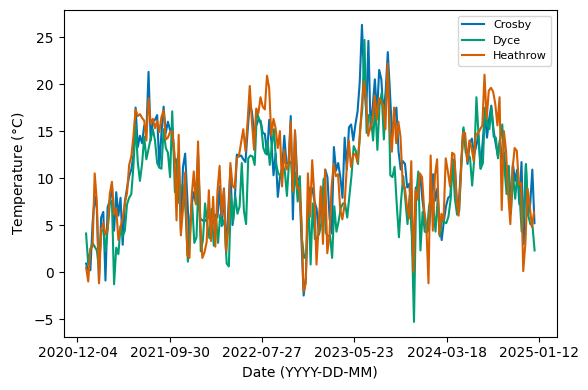

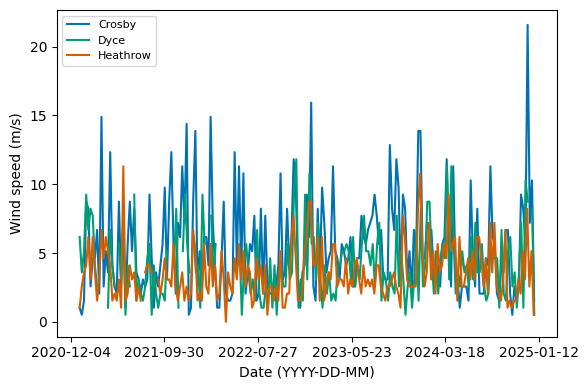

In [24]:
from matplotlib.ticker import MaxNLocator

locations = ['Heathrow', 'Crosby', 'Dyce']

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
for location, group in df_weather.groupby('location'):
    # downsample data to weekly frequency
    timedata = group['ob_time'][::7*24]
    tempdata = group['air_temperature'][::7*24]
    ax.plot(timedata, tempdata, label=location)
ax.legend(fontsize=8)
ax.set_xlabel('Date (YYYY-DD-MM)', fontsize=10)
ax.set_ylabel('Temperature ($\\degree \\mathrm{C}$)', fontsize=10)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Max ~10 ticks
plt.show()

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
for location, group in df_weather.groupby('location'):
    # downsample data to weekly frequency
    timedata = group['ob_time'][::7*24]
    tempdata = group['wind_speed'][::7*24]
    ax.plot(timedata, tempdata, label=location)
ax.legend(fontsize=8)
ax.set_xlabel('Date (YYYY-DD-MM)', fontsize=10)
ax.set_ylabel('Wind speed (m/s)', fontsize=10)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Max ~10 ticks
plt.show()